# **TCN model - feature set 1 dynamic data**

We will now look at constructing a TCN model that can be used to take our dynamic data and predict extubation failure.

TCN stands for Temporal Convolutional Network. Typically CNNs are used for image data i.e. 2D data but the convolutional filter can be made into a 1D conv filter to take in time series data.

A paper by Bai et al. (find reference) has shown that TCNs can perform better than RNN architectures e.g. LSTM. Convolutional layers also allow for greater parallelisation of computation.

**Architecture**

TCNs consist of dilated, casual ID convolution layers with the same input and output lengths. The 1D Convolutional network will take in 3D tensor and output a 3D tensor.

**Casual convolution**

For a convolutional layer to be causal, for every i in {0, …, input_length — 1} the i’th element of the output sequence may only depend on the elements of the input sequence with indices {0, …, i}. In other words, an element in the output sequence can only depend on elements that come before it in the input sequence.
i.e. its baed on past time steps.

**Model improvements**

- Residual blocks
- Activation functions, Normalisation of weights and Regularisation (dropout)



**Key paper**

Temporal convolutional networks allow early prediction of events in critical care

They use TCN for longitudinal data and Linear layer for static data. They compare performance to RNN (like LSTM).

This paper (https://arxiv.org/abs/1803.01271) shows that convolutional architecture outperforms RNN performance.


**Paper on extubation and CNN**

https://www.sciencedirect.com/science/article/pii/S0933365721000804

Jia et al, has used CNNs on time series data to predict weaning in ICU patients.

Their architecture was as follows:
- Conv1D with 64 filters of Kernel size 1
- Conv1D with 128 filters of Kernel size 1
- Conv1D with 256 filters of Kernel size 1
- Conv1D with 256 filters of Kernel size 1
- Dropout with probability 0.5 of leaving out units
- Fully connected layer with 128 neurons
- Sigmoid output

CNN showed better performance than other functions but did not compare to LSTMs.They used DeepLift and Counterfactual Explanations for interpretability.

Code: https://github.com/Yanjiayork/mechanical_ventilator

**Textbook on autoregressive models**

Deep Generative Modelling

Section 2.2.3 Long-Range Memory Through Convolutional Nets




**References:**
- https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/
- https://towardsdatascience.com/temporal-coils-intro-to-temporal-convolutional-networks-for-time-series-forecasting-in-python-5907c04febc6
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7647248/ (Temporal convolutional networks allow early prediction of events in critical care - USE THIS AS REFERENCE PAPER)





We want to apply the same experiment design to our TCN network as was applied to the LSTM network.

Hyperparameters to be tuned:
- Dropout rate
- Activation function
- Learning rate
- L2 regularisation weight decay
- Sampling type
- Weighted Loss

TCN specific:
- Number of layers in temporal block
- Number of channels
- Kernel size

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.nn.utils.parametrizations as param
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import json

**Handling Data**

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            'sequence': torch.tensor(self.sequences[idx].transpose(1, 0), dtype=torch.float32),  # Transpose to (num_features, num_timesteps)
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_data_loaders(train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, batch_size):
    train_dataset = TimeSeriesDataset(train_sequences, train_labels)
    val_dataset = TimeSeriesDataset(val_sequences, val_labels)
    test_dataset = TimeSeriesDataset(test_sequences, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Undersampling and Oversampling**

In [ ]:
def undersample_data(sequences, labels):
    rus = RandomUnderSampler()
    sequences_flat = sequences.reshape(sequences.shape[0], -1)
    sequences_resampled, labels_resampled = rus.fit_resample(sequences_flat, labels)
    sequences_resampled = sequences_resampled.reshape((sequences_resampled.shape[0], sequences.shape[1], sequences.shape[2]))
    return sequences_resampled, labels_resampled

def oversample_data(sequences, labels):
    smote = SMOTE()
    sequences_flat = sequences.reshape(sequences.shape[0], -1)
    sequences_resampled, labels_resampled = smote.fit_resample(sequences_flat, labels)
    sequences_resampled = sequences_resampled.reshape((sequences_resampled.shape[0], sequences.shape[1], sequences.shape[2]))
    return sequences_resampled, labels_resampled

**Early Stopping**

In [ ]:
class EarlyStopping:
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.output_path)

### **Define the TCN model**

The TCN model used in this study is adapted from the paper by Bai et al. (https://arxiv.org/pdf/1803.01271).

https://github.com/locuslab/TCN/blob/master/TCN/tcn.py is their github repo for reference.

Elements are also taken from Catling et al. (https://pubmed.ncbi.nlm.nih.gov/31858114/).

**Chomp1d layer**

Removes extra padding introduced by dilations to maintain the correct sequence length

In [ ]:
# Class designed to trim the end of a sequence - ensuring output length matches input length after padding and dilations
class Chomp1d(nn.Module):
  def __init__(self, chomp_size):
    super(Chomp1d, self).__init__()
    self.chomp_size = chomp_size # The number of elements to remove from the end of the sequence

  def forward(self, x):
    return x[:, :, :-self.chomp_size].contiguous() # Returns the trimmed sequence

**TemporalBlock layer**

Defines a single block of TCN.

In [ ]:
class TemporalBlock(nn.Module):
  def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout):
    super(TemporalBlock, self).__init__()

    # First dilated convolutional layer
    self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                       stride=stride, padding=padding, dilation=dilation)
    self.chomp1 = Chomp1d(padding) # Trim the output of conv 1 to remove padding added for dilation
    self.relu1 = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(n_outputs) # Batch normlisation to make training more robust - not in paper
    self.dropout1 = nn.Dropout(dropout) # Spatial dropout

    # Second dilated convolutional layer
    self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                       stride=stride, padding=padding, dilation=dilation)
    self.chomp2 = Chomp1d(padding) # Trim the output of conv 2 to remove padding added for dilation
    self.relu2 = nn.ReLU()
    self.bn2 = nn.BatchNorm1d(n_outputs) # Batch normlisation to make training more robust
    self.dropout2 = nn.Dropout(dropout) # Spatial dropout

    # Sequential container
    self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.bn1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.bn2, self.dropout2)

    # 1x1 convolutional layer for downsampling if the number of input channels is not equal to the number of output channels
    self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
    self.relu = nn.ReLU()
    self.init_weights()

  # Function to initialize weights of the convolutional layers
  def init_weights(self):
    for layer in self.net:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_normal_(layer.weight)  # Use Kaiming Normal initialization
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)  # Initialize biases to 0
    if self.downsample is not None:
        nn.init.kaiming_normal_(self.downsample.weight)  # Use Kaiming Normal initialization for downsample
        if self.downsample.bias is not None:
            nn.init.constant_(self.downsample.bias, 0)  # Initialize biases to 0

  # Define forward pass funcion
  def forward(self, x):
    out = self.net(x) # Pass input through the sequential container
    res = x if self.downsample is None else self.downsample(x) # If the number of input channels is not equal to the number of output channels, use the 1x1 convolutional layer to downsample the input
    return self.relu(out + res) # Add the residual connection and pass the output through a ReLU activation function

**TemporalConvNet**

Stacks multiple Temporal Blocks to form a TCN network.

In [ ]:
class TCN(nn.Module):
  def __init__(self, num_inputs, num_channels, kernel_size, dropout, seq_length):
    super(TCN, self).__init__()

    layers = []
    num_levels = len(num_channels) # Number of temporal blocks

    for i in range(num_levels):
      dilation_size = 2 ** i # Dilation factor for each temporal block
      in_channels = num_inputs if i == 0 else num_channels[i-1] # Input channels as either num_inputs or output channels from previous block
      out_channels = num_channels[i] # Output channels for current block

      # Append temporal blocks to create network layers
      layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                               dilation=dilation_size, padding=(kernel_size-1) * dilation_size, dropout=dropout)]

      # Stride kept at 1 to preserve sequence length of temporal data and maintain casual convolutions

      # Create sequential container
      self.network = nn.Sequential(*layers)
      self.linear = nn.Linear(num_channels[-1] * seq_length, 1) # Linear layer for output
      self.sigmoid = nn.Sigmoid() # Sigmoid activation function for binary classification
      self.init_weights() # Initialize weights of the network

  # Function to initialize weights of the linear layer
  def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

  # Define forward pass function
  def forward(self, x):
    x = self.network(x) # Pass input through the network layers
    x = x.view(x.size(0), -1) # Flatten the output of the network layers
    x = self.linear(x) # Pass through linear layer
    x = self.sigmoid(x) # Pass through sigmoid activation function
    return x

**Training model**

In [ ]:
def train_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    # Initialise early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=0, output_path=output_path)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences)



            # DEBUG - Debugging prints for outputs and labels
            if torch.isnan(outputs).any():
                print(f"NaN detected in outputs at epoch {epoch}")
                print(f"outputs: {outputs}")
            if torch.isnan(labels).any():
                print(f"NaN detected in labels at epoch {epoch}")
                print(f"labels: {labels}")

            # DEBUG - Check for values out of range [0, 1] in outputs
            if (outputs < 0).any() or (outputs > 1).any():
                print(f"Out of range values detected in outputs at epoch {epoch}")
                print(f"outputs: {outputs}")
                return model, train_losses, val_losses, val_aucs



            loss = criterion(outputs, labels)
            loss.backward()

            # Add gradient clipping with max_norm value set to 1 to help prevent exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []
        with torch.no_grad():
            for data in val_loader:
                sequences = data['sequence'].to(device)
                labels = data['label'].to(device).view(-1, 1)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * sequences.size(0)
                val_outputs.extend(outputs.cpu().numpy().flatten())
                val_labels.extend(labels.cpu().numpy().flatten())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # DEBUG - heck for NaN values in val_outputs and val_labels
        if np.isnan(val_outputs).any() or np.isnan(val_labels).any():
            print(f"NaN detected in validation outputs or labels at epoch {epoch}")
            print(f"val_outputs: {val_outputs}")
            print(f"val_labels: {val_labels}")
            return model, train_losses, val_losses, val_aucs

        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)

        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

**Cross-validation**

In [ ]:
def shuffle_data(sequences, labels):
    assert len(sequences) == len(labels)
    p = np.random.permutation(len(sequences))
    return sequences[p], labels[p]

def split_data_into_folds(sequences, labels, num_folds):
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:
            end_idx = len(sequences)
        else:
            end_idx = start_idx + fold_size
        sequences_folds.append(sequences[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return sequences_folds, labels_folds

In [ ]:
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
def manual_cross_validation(sequences, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    sequences, labels = shuffle_data(sequences, labels)
    sequences_folds, labels_folds = split_data_into_folds(sequences, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        val_sequences = sequences_folds[i]
        val_labels = labels_folds[i]
        train_sequences = np.concatenate([sequences_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        input_dim = train_sequences.shape[2]
        seq_length = train_sequences.shape[1]

        for params in hyperparameters:
            if params['sampling_method'] == 'undersample':
                train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences, train_labels)
            else:
                train_sequences_resampled, train_labels_resampled = train_sequences, train_labels

            train_loader, val_loader, _ = create_data_loaders(
                train_sequences_resampled, train_labels_resampled,
                val_sequences, val_labels,
                val_sequences, val_labels,
                batch_size=params['batch_size']
            )

            model = TCN(
                num_inputs=input_dim,
                num_channels=params['num_channels'],
                kernel_size=params['kernel_size'],
                dropout=params['dropout'],
                seq_length=seq_length
            ).to(device)

            reset_model(model)

            criterion = nn.BCELoss()

            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            val_outputs = []
            val_labels = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    sequences = data['sequence'].to(device)
                    labels = data['label'].to(device).view(-1, 1)
                    outputs = model(sequences)
                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels.extend(labels.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc

**Bayesian Optimisation for Hyperparameter Tuning**

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
# Run Bayesian optimization
def objective_wrapper(train_sequences, train_labels, seq_length, hyperparameter_grid):
    def objective(trial):
        num_channels_str = trial.suggest_categorical('num_channels', hyperparameter_grid['num_channels'])
        num_channels = tuple(map(int, num_channels_str.split(',')))

        kernel_size = trial.suggest_int('kernel_size', min(hyperparameter_grid['kernel_size']), max(hyperparameter_grid['kernel_size']))
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_int('num_epochs', min(hyperparameter_grid['num_epochs']), max(hyperparameter_grid['num_epochs']))
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'num_channels': num_channels,
            'kernel_size': kernel_size,
            'dropout': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay,
            'seq_length': seq_length
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            train_sequences,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

**Final model training**

In [ ]:
import matplotlib.pyplot as plt

def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device, grad_clip=1.0):
    """
    Train the model with the given parameters and plot the training loss.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.
    grad_clip (float): Gradient clipping threshold.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)  # Gradient clipping
            optimizer.step()
            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Plot the training losses at the end of training
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

    return model, train_losses

**Model evaluation on test set**

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate various evaluation metrics.

    Parameters:
    model (nn.Module): The trained model to evaluate.
    test_loader (DataLoader): The DataLoader for the test dataset.
    device (torch.device): The device to run the model on.

    Returns:
    tuple: A tuple containing accuracy, precision, recall, F1 score, ROC AUC, and specificity.
    """
    model.eval()
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]
            outputs = model(sequences)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device)

            outputs = model(sequences)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

**Feature ablation**

In [ ]:
def evaluate_model_ablation(model, data_loader, criterion, device):
    """
    Evaluate the model and calculate various metrics.

    Parameters:
    model (nn.Module): The model to evaluate.
    data_loader (DataLoader): The DataLoader for the dataset.
    criterion (nn.Module): The loss function.
    device (torch.device): The device to run the model on.

    Returns:
    tuple: A tuple containing accuracy, precision, recall, F1 score, ROC AUC, and specificity.
    """
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for data in data_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device)

            outputs = model(sequences)
            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, (all_outputs >= 0.5).astype(int))
    precision = precision_score(all_labels, (all_outputs >= 0.5).astype(int))
    recall = recall_score(all_labels, (all_outputs >= 0.5).astype(int))
    f1 = f1_score(all_labels, (all_outputs >= 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    tn, fp, fn, tp = confusion_matrix(all_labels, (all_outputs >= 0.5).astype(int)).ravel()
    specificity = tn / (tn + fp)

    return accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
def feature_ablation_with_names(train_sequences, train_labels, test_sequences, test_labels, model, best_hyperparams, device, feature_names):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    train_sequences (np.array): The training sequences.
    train_labels (np.array): The training labels.
    test_sequences (np.array): The test sequences.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained TCN model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    feature_names (list): List of feature names.

    Returns:
    feature_importances (dict): Dictionary containing the importance of each feature.
    """
    feature_importances = {}
    input_dim = train_sequences.shape[2]

    criterion = nn.BCELoss()
    base_metrics = evaluate_model_ablation(
        model,
        DataLoader(TimeSeriesDataset(test_sequences, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )
    base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = base_metrics

    for feature_idx in range(input_dim):
        feature_name = feature_names[feature_idx]
        print(f"Ablating feature {feature_name} ({feature_idx + 1}/{input_dim})")

        # Remove the feature from the sequences
        train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
        test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            train_sequences_ablation, train_labels,
            train_sequences_ablation, train_labels,
            test_sequences_ablation, test_labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = TCN(
            num_inputs=input_dim - 1,
            num_channels=[int(x) for x in best_hyperparams['num_channels'].split(',')],
            kernel_size=best_hyperparams['kernel_size'],
            dropout=best_hyperparams['dropout_prob'],
            seq_length=train_sequences.shape[1]
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

        # Train the model
        ablation_model, _, _, _ = train_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        ablation_metrics = evaluate_model_ablation(ablation_model, test_loader, criterion, device)
        accuracy, precision, recall, f1, roc_auc, specificity = ablation_metrics

        feature_importances[feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Convert feature importances to a DataFrame for better readability
    feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index')
    feature_importances_df = feature_importances_df.sort_values(by='roc_auc', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances_df.index, feature_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return feature_importances_df

**Load the data**

In [ ]:
# Load the train and test sequences
train_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_sequences_v3.npy'
train_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_labels_v3.npy'
test_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_sequences_v3.npy'
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_labels_v3.npy'

train_sequences = np.load(train_sequences_path, allow_pickle=True).astype(np.float32)
train_labels = np.load(train_labels_path, allow_pickle=True).astype(np.float32)
test_sequences = np.load(test_sequences_path, allow_pickle=True).astype(np.float32)
test_labels = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train sequences shape: {train_sequences.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train sequences shape: (3760, 13, 12)
Train labels shape: (3760,)
Test sequences shape: (941, 13, 12)
Test labels shape: (941,)


In [ ]:
seq_length = train_sequences.shape[1]
seq_length

13

In [ ]:
# Load the feature names path
feature_names_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/feature_names_v3.npy'
feature_names = np.load(feature_names_path, allow_pickle=True)

# Print the shape of the loaded feature names
print(f"Feature names shape: {feature_names.shape}")

Feature names shape: (12,)


# **Run the model on dummy data**

We will run the model on dummy data first before the MIMIC data to ensure the model is running smoothly.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import torch

# Set the environment variable for CUDA assertions
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Check CUDA availability
print("CUDA available:", torch.cuda.is_available())

# Set manual seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Create a simple tensor and move to GPU (if available)
tensor = torch.tensor([1.0, 2.0, 3.0])
if torch.cuda.is_available():
    tensor = tensor.to('cuda')

print("Tensor:", tensor)


CUDA available: False
Tensor: tensor([1., 2., 3.])


In [ ]:
# Generate dummy data
np.random.seed(42)
torch.manual_seed(42)

num_samples = 100
num_time_steps = 13
num_features = 10

X_dummy = np.random.rand(num_samples, num_time_steps, num_features).astype(np.float32)
y_dummy = np.random.randint(0, 2, size=num_samples).astype(np.float32)

In [ ]:
X_dummy.shape, y_dummy.shape

((100, 13, 10), (100,))

In [ ]:
# Define two hyperparameter combinations
hyperparameters = [
    {
        'num_channels': [16, 32],
        'kernel_size': 2,
        'dropout': 0.3,
        'learning_rate': 0.001,
        'weight_decay': 0.01,
        'batch_size': 16,
        'num_epochs': 5,
        'sampling_method': 'normal',
        'loss': 'standard'
    },
    {
        'num_channels': [32, 64],
        'kernel_size': 3,
        'dropout': 0.4,
        'learning_rate': 0.01,
        'weight_decay': 0.1,
        'batch_size': 32,
        'num_epochs': 5,
        'sampling_method': 'normal',
        'loss': 'standard'
    }
]

In [ ]:
# Run the grid search cross validation
dummy_best_model, dummy_best_hyperparams, dummy_best_auc = manual_cross_validation(
    X_dummy,
    y_dummy,
    hyperparameters,
    num_folds=5,
    patience=5,
    output_path="None"
)

Epoch 0/4, Loss: 0.6989, Val Loss: 0.6968, Val AUC: 0.3838
Epoch 1/4, Loss: 0.6918, Val Loss: 0.7084, Val AUC: 0.4242
Epoch 2/4, Loss: 0.6844, Val Loss: 0.7155, Val AUC: 0.4141
Epoch 3/4, Loss: 0.6844, Val Loss: 0.7143, Val AUC: 0.4141
Epoch 4/4, Loss: 0.6859, Val Loss: 0.7163, Val AUC: 0.4040
Params: {'num_channels': [16, 32], 'kernel_size': 2, 'dropout': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 16, 'num_epochs': 5, 'sampling_method': 'normal', 'loss': 'standard'}, Val AUC: 0.4040
Epoch 0/4, Loss: 0.6910, Val Loss: 0.7477, Val AUC: 0.5354
Epoch 1/4, Loss: 0.6938, Val Loss: 0.7143, Val AUC: 0.6364
Epoch 2/4, Loss: 0.6890, Val Loss: 0.7068, Val AUC: 0.3939
Epoch 3/4, Loss: 0.6870, Val Loss: 0.7003, Val AUC: 0.4040
Epoch 4/4, Loss: 0.6892, Val Loss: 0.7002, Val AUC: 0.6061
Params: {'num_channels': [32, 64], 'kernel_size': 3, 'dropout': 0.4, 'learning_rate': 0.01, 'weight_decay': 0.1, 'batch_size': 32, 'num_epochs': 5, 'sampling_method': 'normal', 'loss': 'standard

KeyboardInterrupt: 

In [ ]:
print(f"Best hyperparameters: {dummy_best_hyperparams}")
print(f"Best AUC: {dummy_best_auc}")

Best hyperparameters: {'num_channels': [32, 64], 'kernel_size': 3, 'dropout': 0.4, 'learning_rate': 0.01, 'weight_decay': 0.1, 'batch_size': 32, 'num_epochs': 5, 'sampling_method': 'normal', 'loss': 'standard'}
Best AUC: 0.6900000000000001


The model seems to run with no dimensional issues so we can now run our data.

# **Experiment 1**

We will load the time series data and run Bayesian optimisation for hyperparameter tuning.

In [ ]:
import itertools

In [ ]:
# Hyperparameter grid
param_grid_exp_1 = {
    'num_channels': [
        '16,32', '32,64', '64,128', '128,256',
        '16,32,64', '32,64,128', '64,128,256'
    ],
    'kernel_size': list(range(2, 11)),  # Kernel sizes from 2 to 10
    'dropout_prob': [0.0, 0.2, 0.4, 0.6, 0.8],
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2]
}

param_combinations = list(itertools.product(*param_grid_exp_1.values()))

param_combinations = [dict(zip(param_grid_exp_1.keys(), combination))
  for combination in param_combinations]


print(f"Number of hyperparameter combinations: {len(param_combinations)}")

Number of hyperparameter combinations: 1512000


**TCN specific hyperparameters**

num_channels: Starting with smaller values (like [16, 32]) ensures the model starts with fewer parameters and computational cost. Increasing to larger values (like [64, 128, 256]) allows the model to capture more complex patterns in the data. Including configurations with three layers provides an opportunity to explore deeper network architectures, which can be beneficial for capturing hierarchical features in time series data.

kernel_size: Kernel sizes from 2 to 10 provide a broad range of temporal receptive fields. Smaller kernels (like 2) focus on very local patterns, whereas larger kernels (up to 10) can capture more extended temporal dependencies. This range allows the model to adapt to the temporal structure of the data, whether short-term or long-term dependencies are more important.


**Run the Bayesian Optimisation**

As with LSTM we will run Bayesian Optimisation with 100 trials.



[I 2024-07-23 14:24:50,991] A new study created in memory with name: no-name-27f2fc98-4b49-4921-b95e-8d691b4dabc4


Epoch 0/65, Loss: 0.6934, Val Loss: 0.6905, Val AUC: 0.6070
Epoch 1/65, Loss: 0.6932, Val Loss: 0.6936, Val AUC: 0.6415
Epoch 2/65, Loss: 0.6932, Val Loss: 0.6959, Val AUC: 0.6397
Epoch 3/65, Loss: 0.6932, Val Loss: 0.6934, Val AUC: 0.6405
Epoch 4/65, Loss: 0.6925, Val Loss: 0.6890, Val AUC: 0.6423
Epoch 5/65, Loss: 0.6899, Val Loss: 0.6739, Val AUC: 0.6412
Epoch 6/65, Loss: 0.6830, Val Loss: 0.6779, Val AUC: 0.6418
Epoch 7/65, Loss: 0.6735, Val Loss: 0.6583, Val AUC: 0.6417
Epoch 8/65, Loss: 0.6756, Val Loss: 0.6911, Val AUC: 0.6428
Epoch 9/65, Loss: 0.6693, Val Loss: 0.6678, Val AUC: 0.6432
Epoch 10/65, Loss: 0.6714, Val Loss: 0.6817, Val AUC: 0.6431
Epoch 11/65, Loss: 0.6677, Val Loss: 0.6683, Val AUC: 0.6441
Epoch 12/65, Loss: 0.6675, Val Loss: 0.6392, Val AUC: 0.6436
Epoch 13/65, Loss: 0.6667, Val Loss: 0.6467, Val AUC: 0.6439
Epoch 14/65, Loss: 0.6653, Val Loss: 0.6470, Val AUC: 0.6444
Epoch 15/65, Loss: 0.6653, Val Loss: 0.6392, Val AUC: 0.6444
Epoch 16/65, Loss: 0.6620, Val Los

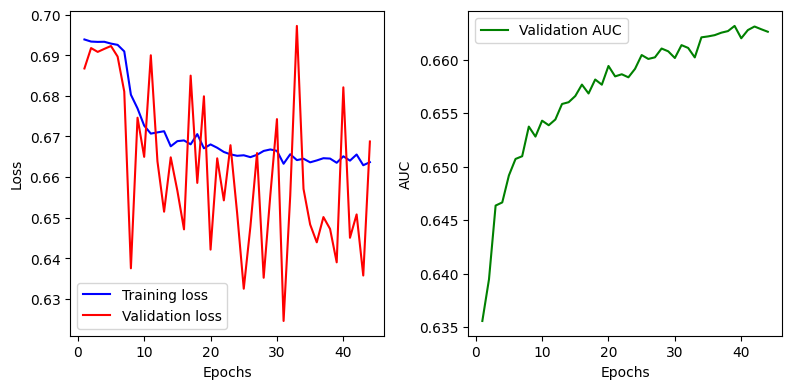

[I 2024-07-23 14:25:40,257] Trial 0 finished with value: -0.6626137650795663 and parameters: {'num_channels': '32,64', 'kernel_size': 9, 'dropout_prob': 0.2, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 66, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.001}. Best is trial 0 with value: -0.6626137650795663.


Epoch 0/61, Loss: 0.6447, Val Loss: 0.6287, Val AUC: 0.6117
Epoch 1/61, Loss: 0.6347, Val Loss: 0.6278, Val AUC: 0.6129
Epoch 2/61, Loss: 0.6312, Val Loss: 0.6251, Val AUC: 0.6189
Epoch 3/61, Loss: 0.6251, Val Loss: 0.6163, Val AUC: 0.6247
Epoch 4/61, Loss: 0.6175, Val Loss: 0.6071, Val AUC: 0.6257
Epoch 5/61, Loss: 0.6142, Val Loss: 0.6125, Val AUC: 0.6292
Epoch 6/61, Loss: 0.6144, Val Loss: 0.6070, Val AUC: 0.6313
Epoch 7/61, Loss: 0.6172, Val Loss: 0.6092, Val AUC: 0.6320
Epoch 8/61, Loss: 0.6127, Val Loss: 0.6021, Val AUC: 0.6335
Epoch 9/61, Loss: 0.6104, Val Loss: 0.6007, Val AUC: 0.6353
Epoch 10/61, Loss: 0.6134, Val Loss: 0.6009, Val AUC: 0.6369
Epoch 11/61, Loss: 0.6094, Val Loss: 0.6010, Val AUC: 0.6389
Epoch 12/61, Loss: 0.6127, Val Loss: 0.6031, Val AUC: 0.6383
Epoch 13/61, Loss: 0.6096, Val Loss: 0.5989, Val AUC: 0.6382
Epoch 14/61, Loss: 0.6151, Val Loss: 0.6033, Val AUC: 0.6369
Epoch 15/61, Loss: 0.6130, Val Loss: 0.5987, Val AUC: 0.6392
Epoch 16/61, Loss: 0.6093, Val Los

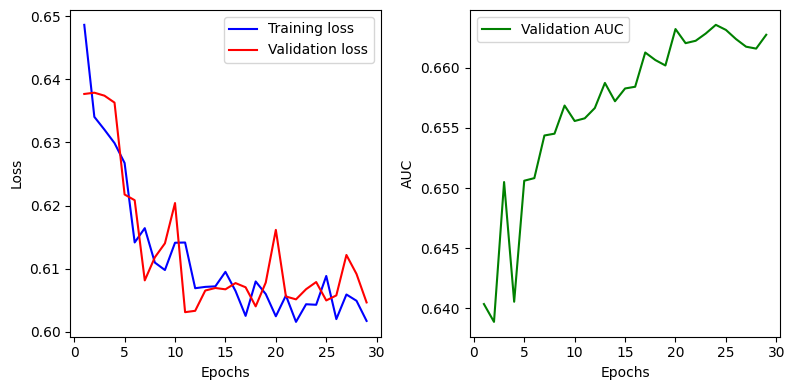

[I 2024-07-23 14:26:04,890] Trial 1 finished with value: -0.6627539682539683 and parameters: {'num_channels': '64,128,256', 'kernel_size': 5, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 256, 'num_epochs': 62, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.0001}. Best is trial 1 with value: -0.6627539682539683.


Epoch 0/46, Loss: 0.8861, Val Loss: 0.8886, Val AUC: 0.4127
Epoch 1/46, Loss: 0.8710, Val Loss: 0.8812, Val AUC: 0.4409
Epoch 2/46, Loss: 0.8557, Val Loss: 0.8723, Val AUC: 0.4638
Epoch 3/46, Loss: 0.8425, Val Loss: 0.8611, Val AUC: 0.4722
Epoch 4/46, Loss: 0.8290, Val Loss: 0.8496, Val AUC: 0.4781
Epoch 5/46, Loss: 0.8214, Val Loss: 0.8389, Val AUC: 0.4827
Epoch 6/46, Loss: 0.8178, Val Loss: 0.8312, Val AUC: 0.4855
Epoch 7/46, Loss: 0.8153, Val Loss: 0.8269, Val AUC: 0.4892
Epoch 8/46, Loss: 0.8149, Val Loss: 0.8242, Val AUC: 0.4918
Epoch 9/46, Loss: 0.8143, Val Loss: 0.8223, Val AUC: 0.4939
Epoch 10/46, Loss: 0.8135, Val Loss: 0.8211, Val AUC: 0.4953
Epoch 11/46, Loss: 0.8135, Val Loss: 0.8207, Val AUC: 0.4965
Epoch 12/46, Loss: 0.8135, Val Loss: 0.8200, Val AUC: 0.4971
Epoch 13/46, Loss: 0.8134, Val Loss: 0.8193, Val AUC: 0.4979
Epoch 14/46, Loss: 0.8133, Val Loss: 0.8188, Val AUC: 0.4989
Epoch 15/46, Loss: 0.8133, Val Loss: 0.8183, Val AUC: 0.4993
Epoch 16/46, Loss: 0.8131, Val Los

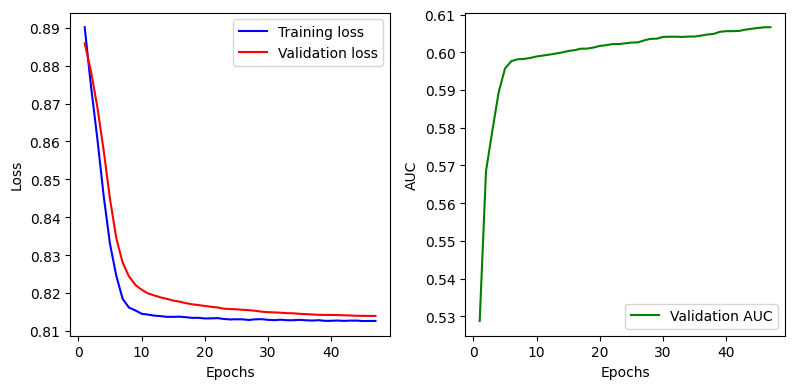

[I 2024-07-23 14:26:31,477] Trial 2 finished with value: -0.6066572452833202 and parameters: {'num_channels': '64,128', 'kernel_size': 3, 'dropout_prob': 0.8, 'learning_rate': 0.0001, 'batch_size': 256, 'num_epochs': 47, 'sampling_method': 'normal', 'loss': 'weighted', 'weight_decay': 0.01}. Best is trial 1 with value: -0.6627539682539683.


Epoch 0/95, Loss: 0.7020, Val Loss: 0.7018, Val AUC: 0.5798
Epoch 1/95, Loss: 0.7006, Val Loss: 0.7004, Val AUC: 0.5816
Epoch 2/95, Loss: 0.6993, Val Loss: 0.6990, Val AUC: 0.5832
Epoch 3/95, Loss: 0.6979, Val Loss: 0.6976, Val AUC: 0.5844
Epoch 4/95, Loss: 0.6966, Val Loss: 0.6962, Val AUC: 0.5848
Epoch 5/95, Loss: 0.6953, Val Loss: 0.6948, Val AUC: 0.5848
Epoch 6/95, Loss: 0.6941, Val Loss: 0.6935, Val AUC: 0.5863
Epoch 7/95, Loss: 0.6929, Val Loss: 0.6922, Val AUC: 0.5895
Epoch 8/95, Loss: 0.6916, Val Loss: 0.6909, Val AUC: 0.5903
Epoch 9/95, Loss: 0.6903, Val Loss: 0.6896, Val AUC: 0.5848
Epoch 10/95, Loss: 0.6891, Val Loss: 0.6884, Val AUC: 0.5808
Epoch 11/95, Loss: 0.6879, Val Loss: 0.6871, Val AUC: 0.5902
Epoch 12/95, Loss: 0.6867, Val Loss: 0.6858, Val AUC: 0.6047
Epoch 13/95, Loss: 0.6855, Val Loss: 0.6846, Val AUC: 0.6073
Epoch 14/95, Loss: 0.6843, Val Loss: 0.6833, Val AUC: 0.6071
Epoch 15/95, Loss: 0.6831, Val Loss: 0.6821, Val AUC: 0.6031
Epoch 16/95, Loss: 0.6820, Val Los

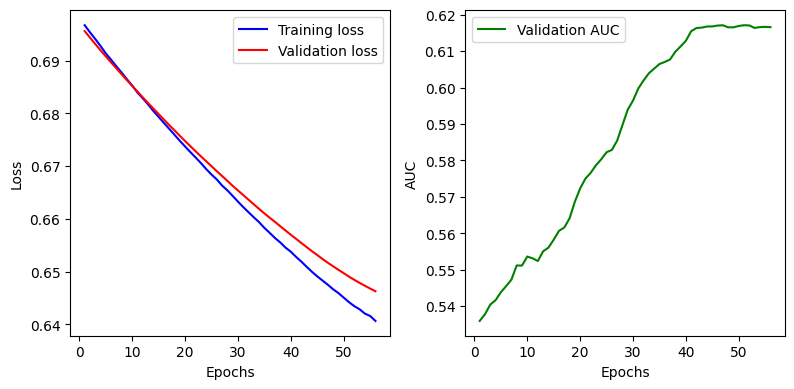

[I 2024-07-23 14:26:52,452] Trial 3 finished with value: -0.6165897344853435 and parameters: {'num_channels': '16,32,64', 'kernel_size': 8, 'dropout_prob': 0.2, 'learning_rate': 1e-05, 'batch_size': 256, 'num_epochs': 96, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.01}. Best is trial 1 with value: -0.6627539682539683.


Epoch 0/19, Loss: 0.8155, Val Loss: 0.8172, Val AUC: 0.6165
Epoch 1/19, Loss: 0.8136, Val Loss: 0.8173, Val AUC: 0.5000
Epoch 2/19, Loss: 0.8136, Val Loss: 0.8172, Val AUC: 0.5000
Epoch 3/19, Loss: 0.8136, Val Loss: 0.8172, Val AUC: 0.5000
Epoch 4/19, Loss: 0.8136, Val Loss: 0.8172, Val AUC: 0.5000


[W 2024-07-23 14:26:56,387] Trial 4 failed with parameters: {'num_channels': '16,32,64', 'kernel_size': 3, 'dropout_prob': 0.6, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted', 'weight_decay': 0.001} because of the following error: ValueError('Input contains NaN.').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-35-1b84321ef264>", line 34, in objective
    best_model, best_hyperparams, best_auc = manual_cross_validation(
  File "<ipython-input-13-1ac9e98aba47>", line 55, in manual_cross_validation
    model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
  File "<ipython-input-10-89ae9a061183>", line 46, in train_model_with_early_stopping_logging
    val_auc = roc_auc_score(val_labels, val_outputs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/m

ValueError: Input contains NaN.

In [ ]:
study_exp_1 = optuna.create_study(direction='minimize')
study_exp_1.optimize(objective_wrapper(train_sequences, train_labels, seq_legth, param_grid_exp_1), n_trials=100)

best_params_exp_1 = study_exp_1.best_params
best_auc_exp_1 = -study_exp_1.best_value

# Save best params as json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/01_dynamic_data/best_models/experiment_1/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params_exp_1, f)

print(f"Best hyperparameters: {best_params_exp_1}")
print(f"Best AUC: {best_auc_exp_1}")

An error indicates that the roc_auc function is recieving a NaN value in either the val_labels, val_outputs or both.

This could happen due to exploding gradients, if the gradients become too large or due to data preprocessing issues. It can also happen due to numerical instability e.g. dividing by zero.

**Debugging issue**

We will first check for NaNs in the input data.

In [ ]:
# Check for NaNs in the training data
print(f"NaNs in train_sequences: {np.isnan(train_sequences).any()}")
print(f"NaNs in train_labels: {np.isnan(train_labels).any()}")

# Check for NaNs in the test data
print(f"NaNs in test_sequences: {np.isnan(test_sequences).any()}")
print(f"NaNs in test_labels: {np.isnan(test_labels).any()}")

NaNs in train_sequences: False
NaNs in train_labels: False
NaNs in test_sequences: False
NaNs in test_labels: False


The input data has no NaNs so we will debug the model training validation data.

[I 2024-07-23 14:35:39,035] A new study created in memory with name: no-name-2e39f11f-8f44-4094-9cbf-37f109b0af75
[I 2024-07-23 14:35:39,040] Trial 0 pruned. 


Epoch 0/99, Loss: 0.6933, Val Loss: 0.6937, Val AUC: 0.6126
Epoch 1/99, Loss: 0.6932, Val Loss: 0.6920, Val AUC: 0.6314
Epoch 2/99, Loss: 0.6932, Val Loss: 0.6943, Val AUC: 0.6415
Epoch 3/99, Loss: 0.6932, Val Loss: 0.6939, Val AUC: 0.6463
Epoch 4/99, Loss: 0.6931, Val Loss: 0.6932, Val AUC: 0.6511
Epoch 5/99, Loss: 0.6929, Val Loss: 0.6936, Val AUC: 0.6575
Epoch 6/99, Loss: 0.6916, Val Loss: 0.6892, Val AUC: 0.6594
Epoch 7/99, Loss: 0.6882, Val Loss: 0.6660, Val AUC: 0.6591
Epoch 8/99, Loss: 0.6775, Val Loss: 0.6457, Val AUC: 0.6594
Epoch 9/99, Loss: 0.6718, Val Loss: 0.7057, Val AUC: 0.6609
Epoch 10/99, Loss: 0.6704, Val Loss: 0.6772, Val AUC: 0.6610
Epoch 11/99, Loss: 0.6695, Val Loss: 0.6469, Val AUC: 0.6603
Epoch 12/99, Loss: 0.6673, Val Loss: 0.6815, Val AUC: 0.6618
Epoch 13/99, Loss: 0.6679, Val Loss: 0.6616, Val AUC: 0.6620
Epoch 14/99, Loss: 0.6678, Val Loss: 0.6632, Val AUC: 0.6623
Epoch 15/99, Loss: 0.6675, Val Loss: 0.6953, Val AUC: 0.6624
Epoch 16/99, Loss: 0.6669, Val Los

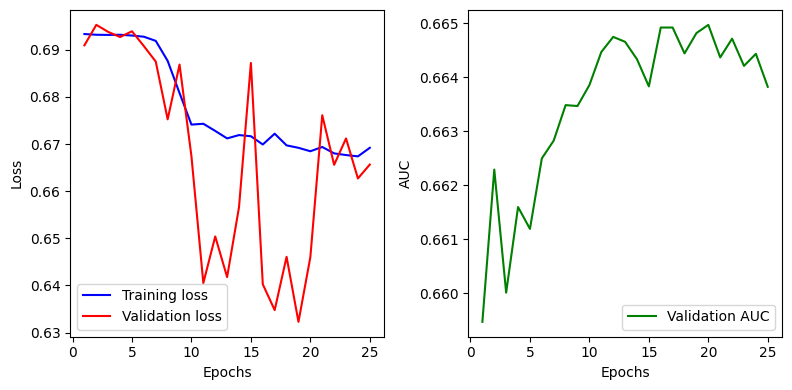

[I 2024-07-23 14:36:17,007] Trial 1 finished with value: -0.6638204138204138 and parameters: {'num_channels': '64,128,256', 'kernel_size': 6, 'dropout_prob': 0.0, 'learning_rate': 0.0001, 'batch_size': 256, 'num_epochs': 100, 'sampling_method': 'oversample', 'loss': 'normal', 'weight_decay': 0.0001}. Best is trial 1 with value: -0.6638204138204138.


Epoch 0/34, Loss: 0.6966, Val Loss: 0.6867, Val AUC: 0.5480
Epoch 1/34, Loss: 0.6952, Val Loss: 0.6952, Val AUC: 0.5977
Epoch 2/34, Loss: 0.6948, Val Loss: 0.6915, Val AUC: 0.5999
Epoch 3/34, Loss: 0.6939, Val Loss: 0.6976, Val AUC: 0.6105
Epoch 4/34, Loss: 0.6925, Val Loss: 0.6745, Val AUC: 0.6156
Epoch 5/34, Loss: 0.6912, Val Loss: 0.6879, Val AUC: 0.6276
Epoch 6/34, Loss: 0.6872, Val Loss: 0.6960, Val AUC: 0.6291
Epoch 7/34, Loss: 0.6829, Val Loss: 0.6961, Val AUC: 0.6325
Epoch 8/34, Loss: 0.6752, Val Loss: 0.6767, Val AUC: 0.6332
Epoch 9/34, Loss: 0.6723, Val Loss: 0.6956, Val AUC: 0.6348


[W 2024-07-23 14:36:25,895] Trial 2 failed with parameters: {'num_channels': '64,128,256', 'kernel_size': 4, 'dropout_prob': 0.8, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 35, 'sampling_method': 'oversample', 'loss': 'normal', 'weight_decay': 0.001} because of the following error: RuntimeError('CUDA error: device-side assert triggered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-35-1b84321ef264>", line 34, in objective
    best_model, best_hyperparams, best_auc = manual_cross_validation(
  File "<ipython-input-13-1ac9e98aba47>", line 55, in manual_cross_validation
    model, train_

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
study_exp_1_1 = optuna.create_study(direction='minimize')
study_exp_1_1.optimize(objective_wrapper(train_sequences, train_labels, seq_legth, param_grid_exp_1), n_trials=100)

best_params_exp_1_1 = study_exp_1_1.best_params
best_auc_exp_1_1 = -study_exp_1_1.best_value

print(f"Best hyperparameters: {best_params_exp_1_1}")
print(f"Best AUC: {best_auc_exp_1_1}")

The error CUDA error: device-side assert triggered usually indicates an issue with the inputs or targets, particularly in the context of loss computation or model predictions.

We will try and debug to see where the issue is.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Check if labels contain only 0 and 1
unique_labels = np.unique(train_labels)
if not np.all(np.isin(unique_labels, [0, 1])):
    print(f"Labels contain values other than 0 and 1: {unique_labels}")
else:
    print("Labels contain only 0 and 1")

Labels contain only 0 and 1


In [ ]:
# Set the environment variable for CUDA assertions
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Example usage
study = optuna.create_study(direction='minimize')
study.optimize(objective_wrapper(train_sequences, train_labels, seq_legth, param_grid_exp_1), n_trials=100)

print("Best hyperparameters: ", study.best_params)
print("Best AUC: ", -study.best_value)

[I 2024-07-23 14:53:14,598] A new study created in memory with name: no-name-dd66764f-a675-40b6-88fc-6dd0b2ef46d5
[W 2024-07-23 14:53:14,625] Trial 0 failed with parameters: {'num_channels': '32,64,128', 'kernel_size': 3, 'dropout_prob': 0.4, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 34, 'sampling_method': 'normal', 'loss': 'weighted', 'weight_decay': 0.0001} because of the following error: RuntimeError('CUDA error: device-side assert triggered\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-17-1b84321ef264>", line 34, in objective
    best_model, best_hyperparams, best_auc = manual_cross_validation(
  File "<ipython-input-14-5ea5dbd1759a>", line 43, in manual_cross_validation
    ).to(device)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Add these imports at the top of your file
import torch
import numpy as np

# If the issue persists, try reducing the number of trials in your Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective_wrapper(train_sequences, train_labels, seq_legth, param_grid_exp_1), n_trials=10)  # Reduce trials

print("Best hyperparameters: ", study.best_params)
print("Best AUC: ", -study.best_value)

TypeError: isnan(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_wrapper(train_sequences, train_labels, seq_legth, param_grid_exp_1), n_trials=100)

print("Best hyperparameters: ", study.best_params)
print("Best AUC: ", -study.best_value)

[I 2024-07-23 15:02:53,621] A new study created in memory with name: no-name-ea10de8e-1bce-40ed-94bb-3a7201201bfd


Epoch 0/45, Loss: 0.6956, Val Loss: 0.7203, Val AUC: 0.6044
Epoch 1/45, Loss: 0.6939, Val Loss: 0.6821, Val AUC: 0.5023
Epoch 2/45, Loss: 0.6935, Val Loss: 0.6864, Val AUC: 0.6080
Epoch 3/45, Loss: 0.6936, Val Loss: 0.6931, Val AUC: 0.4888
Epoch 4/45, Loss: 0.6934, Val Loss: 0.6906, Val AUC: 0.6212
Epoch 5/45, Loss: 0.6934, Val Loss: 0.6907, Val AUC: 0.6132
Epoch 6/45, Loss: 0.6932, Val Loss: 0.6937, Val AUC: 0.6139
Epoch 7/45, Loss: 0.6931, Val Loss: 0.6912, Val AUC: 0.6205
Epoch 8/45, Loss: 0.6925, Val Loss: 0.6845, Val AUC: 0.6273
Epoch 9/45, Loss: 0.6834, Val Loss: 0.6198, Val AUC: 0.6272
Epoch 10/45, Loss: 0.6711, Val Loss: 0.6484, Val AUC: 0.6339
Epoch 11/45, Loss: 0.6678, Val Loss: 0.6348, Val AUC: 0.6360
Epoch 12/45, Loss: 0.6683, Val Loss: 0.6202, Val AUC: 0.6340
Epoch 13/45, Loss: 0.6691, Val Loss: 0.6647, Val AUC: 0.6314
Epoch 14/45, Loss: 0.6659, Val Loss: 0.6361, Val AUC: 0.6324
Epoch 15/45, Loss: 0.6655, Val Loss: 0.6608, Val AUC: 0.6292
Epoch 16/45, Loss: 0.6637, Val Los

[W 2024-07-23 15:04:24,924] Trial 0 failed with parameters: {'num_channels': '16,32,64', 'kernel_size': 8, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 46, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 1e-05} because of the following error: RuntimeError('all elements of input should be between 0 and 1').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-22-1b84321ef264>", line 34, in objective
    best_model, best_hyperparams, best_auc = manual_cross_validation(
  File "<ipython-input-13-5ea5dbd1759a>", line 59, in manual_cross_validation
    model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
  File "<ipython-input-10-53333444b1d3>", line 39, in train_model_with_early_stopping_logging
    loss = criterion(outputs, labels)
  File "/usr/local/lib/python3.10/dist

NaN detected in outputs at epoch 28
outputs: tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<SigmoidBackward0>)


RuntimeError: all elements of input should be between 0 and 1

The error RuntimeError: all elements of input should be between 0 and 1 occurs because the binary_cross_entropy function expects its input to be probabilities between 0 and 1. This usually happens if the sigmoid activation is not applied correctly or if there are issues in the network that cause the outputs to be out of the expected range.

To try and fix this we will clamp the outputs of the signmoid function to be within 0 and 1.

The issue of the outputs being NaNs is to do with numerical instability and likley exploding or vanishing gradients.

This can be dealth with by looking at weight initialisation and normalisation.

**Experiment 1e**

We will amend the TemporalBlock class to remove the param.weight_norm on the Conv1d layers which could introduce numerical instability is the model is not carefully tuned.

We will properly initialise the conv1d layers as well as the linear layers in the TCN model by using Kaiming initialisation rather than just simple normal initialisation.

We will also include Batch normalisation to try and stabilise training. The use of channel normalisation was indicated in (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7647248/#sup1) Catling et al.

We will also add gradient clipping to prevent exploding gradients - this is added after the backward pass in the training function. The gradient clip value of 1 has been set.

[I 2024-07-23 21:32:51,031] A new study created in memory with name: no-name-4e79f569-e80f-49e7-8cbe-5280212e107b
[I 2024-07-23 21:32:51,035] Trial 0 pruned. 
[I 2024-07-23 21:32:51,038] Trial 1 pruned. 


Epoch 0/79, Loss: 0.6769, Val Loss: 0.6873, Val AUC: 0.4631
Epoch 1/79, Loss: 0.6527, Val Loss: 0.6661, Val AUC: 0.4737
Epoch 2/79, Loss: 0.6474, Val Loss: 0.6389, Val AUC: 0.4906
Epoch 3/79, Loss: 0.6400, Val Loss: 0.6295, Val AUC: 0.5088
Epoch 4/79, Loss: 0.6357, Val Loss: 0.6257, Val AUC: 0.5206
Epoch 5/79, Loss: 0.6309, Val Loss: 0.6226, Val AUC: 0.5311
Epoch 6/79, Loss: 0.6297, Val Loss: 0.6217, Val AUC: 0.5356
Epoch 7/79, Loss: 0.6268, Val Loss: 0.6189, Val AUC: 0.5470
Epoch 8/79, Loss: 0.6245, Val Loss: 0.6178, Val AUC: 0.5510
Epoch 9/79, Loss: 0.6223, Val Loss: 0.6162, Val AUC: 0.5578
Epoch 10/79, Loss: 0.6224, Val Loss: 0.6152, Val AUC: 0.5622
Epoch 11/79, Loss: 0.6200, Val Loss: 0.6140, Val AUC: 0.5650
Epoch 12/79, Loss: 0.6172, Val Loss: 0.6136, Val AUC: 0.5671
Epoch 13/79, Loss: 0.6174, Val Loss: 0.6133, Val AUC: 0.5702
Epoch 14/79, Loss: 0.6163, Val Loss: 0.6123, Val AUC: 0.5722
Epoch 15/79, Loss: 0.6163, Val Loss: 0.6125, Val AUC: 0.5740
Epoch 16/79, Loss: 0.6149, Val Los

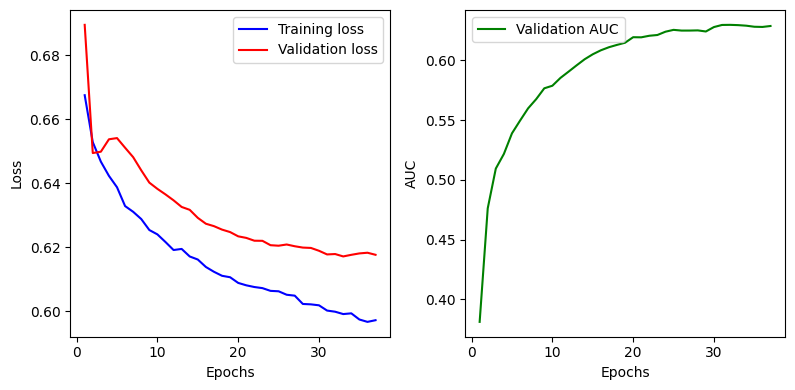

[I 2024-07-23 21:35:22,073] Trial 2 finished with value: -0.6287450191344143 and parameters: {'num_channels': '32,64', 'kernel_size': 10, 'dropout_prob': 0.0, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 80, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.01}. Best is trial 2 with value: -0.6287450191344143.


Epoch 0/58, Loss: 0.8572, Val Loss: 0.8602, Val AUC: 0.5096
Epoch 1/58, Loss: 0.8493, Val Loss: 0.8533, Val AUC: 0.5182
Epoch 2/58, Loss: 0.8410, Val Loss: 0.8490, Val AUC: 0.5041
Epoch 3/58, Loss: 0.8357, Val Loss: 0.8444, Val AUC: 0.5227
Epoch 4/58, Loss: 0.8314, Val Loss: 0.8436, Val AUC: 0.5117
Epoch 5/58, Loss: 0.8283, Val Loss: 0.8414, Val AUC: 0.5240
Epoch 6/58, Loss: 0.8276, Val Loss: 0.8404, Val AUC: 0.5188
Epoch 7/58, Loss: 0.8260, Val Loss: 0.8383, Val AUC: 0.5329
Epoch 8/58, Loss: 0.8249, Val Loss: 0.8374, Val AUC: 0.5266
Epoch 9/58, Loss: 0.8228, Val Loss: 0.8364, Val AUC: 0.5342
Epoch 10/58, Loss: 0.8222, Val Loss: 0.8362, Val AUC: 0.5360
Epoch 11/58, Loss: 0.8219, Val Loss: 0.8355, Val AUC: 0.5390
Epoch 12/58, Loss: 0.8217, Val Loss: 0.8349, Val AUC: 0.5356
Epoch 13/58, Loss: 0.8211, Val Loss: 0.8347, Val AUC: 0.5300
Epoch 14/58, Loss: 0.8202, Val Loss: 0.8340, Val AUC: 0.5390
Epoch 15/58, Loss: 0.8206, Val Loss: 0.8341, Val AUC: 0.5355
Epoch 16/58, Loss: 0.8198, Val Los

[W 2024-07-23 21:39:53,779] Trial 3 failed with parameters: {'num_channels': '16,32', 'kernel_size': 7, 'dropout_prob': 0.2, 'learning_rate': 1e-05, 'batch_size': 16, 'num_epochs': 59, 'sampling_method': 'normal', 'loss': 'weighted', 'weight_decay': 0.0001} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-19-1b84321ef264>", line 34, in objective
    best_model, best_hyperparams, best_auc = manual_cross_validation(
  File "<ipython-input-16-5ea5dbd1759a>", line 59, in manual_cross_validation
    model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
  File "<ipython-input-13-48a7baf61633>", line 43, in train_model_with_early_stopping_logging
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 525, in backward
    torch.autogr

KeyboardInterrupt: 

In [ ]:
study_exp_1e = optuna.create_study(direction='minimize')
study_exp_1e.optimize(objective_wrapper(train_sequences, train_labels, seq_legth, param_grid_exp_1), n_trials=100)

best_params_exp_1e = study_exp.best_params
best_auc_exp_1e = -study_exp.best_value

print(f"Best hyperparameters: {best_params_exp_1e}")
print(f"Best AUC: {best_auc_exp_1e}")

The Bayesian Optimisation seems to be running without flagging the exploding gradient error so we will run a full experiment to optimise the hyperparameters.

# **Experiment 2**

We will now run a full Bayesian Optimisation experiment with 100 trials to tune hyperparameters.

In [ ]:
# Hyperparameter grid
param_grid_exp_2 = {
    'num_channels': [
        '16,32', '32,64', '64,128', '128,256',
        '16,32,64', '32,64,128', '64,128,256'
    ],
    'kernel_size': list(range(2, 11)),  # Kernel sizes from 2 to 10
    'dropout_prob': [0.0, 0.2, 0.4, 0.6, 0.8],
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2]
}

param_combinations = list(itertools.product(*param_grid_exp_2.values()))

param_combinations = [dict(zip(param_grid_exp_2.keys(), combination))
  for combination in param_combinations]


print(f"Number of hyperparameter combinations: {len(param_combinations)}")

Number of hyperparameter combinations: 1512000


In [ ]:
study_exp_2 = optuna.create_study(direction='minimize')
study_exp_2.optimize(objective_wrapper(train_sequences, train_labels, seq_legth, param_grid_exp_2), n_trials=100)

best_params_exp_2 = study_exp_2.best_params
best_auc_exp_2 = -study_exp_2.best_value

# Save the best hyperparams
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/01_dynamic_data/best_models/experiment_2/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params_exp_2, f)

print(f"Best hyperparameters: {best_params_exp_2}")
print(f"Best AUC: {best_auc_exp_2}")

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'num_channels': '32,64,128', 'kernel_size': 6, 'dropout_prob': 0.6, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 60, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 1e-05}

Best AUC: 0.709348513598988

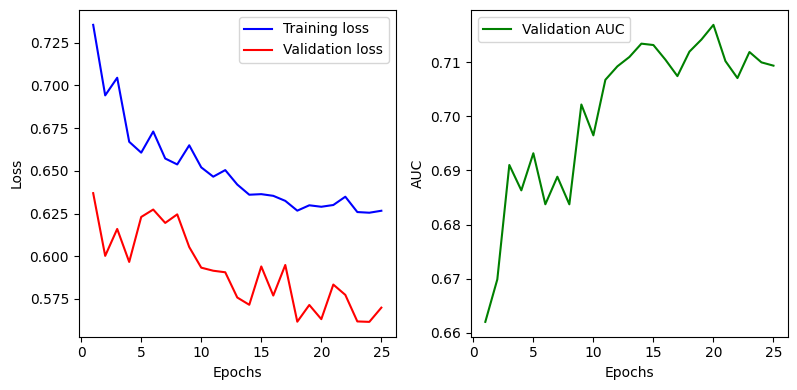

**Train and evaluate final model**

In [ ]:
# Load best hyperparameters
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/01_dynamic_data/best_models/experiment_2/best_params.json'
with open(params_path, 'r') as f:
    best_params = json.load(f)

best_params

{'num_channels': '32,64,128',
 'kernel_size': 6,
 'dropout_prob': 0.6,
 'learning_rate': 0.001,
 'batch_size': 64,
 'num_epochs': 60,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 1e-05}

In [ ]:
# Set up model
final_model = TCN(
    num_inputs=train_sequences.shape[2],
    num_channels=[int(x) for x in best_params['num_channels'].split(',')],
    kernel_size=best_params['kernel_size'],
    dropout=best_params['dropout_prob'],
    seq_length=seq_length
).to(device)
final_model

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(12, 32, kernel_size=(6,), stride=(1,), padding=(5,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout1): Dropout(p=0.6, inplace=False)
      (conv2): Conv1d(32, 32, kernel_size=(6,), stride=(1,), padding=(5,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout2): Dropout(p=0.6, inplace=False)
      (net): Sequential(
        (0): Conv1d(12, 32, kernel_size=(6,), stride=(1,), padding=(5,))
        (1): Chomp1d()
        (2): ReLU()
        (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.6, inplace=False)
        (5): Conv1d(32, 32, kernel_size=(6,), stride=(1,), padding=(5,))
        (6): Chomp1d()
        (7): ReLU()
        (8): BatchNorm1d(

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'oversampling':
    train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences, train_labels)
elif best_params['sampling_method'] == 'undersampling':
    train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences, train_labels)
else:
    train_sequences_resampled, train_labels_resampled = train_sequences, train_labels

# Define the loss function
if best_params['loss'] == 'weighted':
    pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    criterion = nn.BCELoss()

# Define the optimizer with learning rate and L2 weight decay
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
train_loader, _, test_loader = create_data_loaders(
    train_sequences_resampled, train_labels_resampled,
    _, _,
    test_sequences, test_labels,
    batch_size=best_params['batch_size']
)

In [ ]:
reset_model(final_model)

Epoch 1/60, Loss: 0.6214
Epoch 2/60, Loss: 0.6022
Epoch 3/60, Loss: 0.6080
Epoch 4/60, Loss: 0.6031
Epoch 5/60, Loss: 0.6085
Epoch 6/60, Loss: 0.6056
Epoch 7/60, Loss: 0.6044
Epoch 8/60, Loss: 0.6042
Epoch 9/60, Loss: 0.6043
Epoch 10/60, Loss: 0.6032
Epoch 11/60, Loss: 0.6045
Epoch 12/60, Loss: 0.6052
Epoch 13/60, Loss: 0.6017
Epoch 14/60, Loss: 0.6014
Epoch 15/60, Loss: 0.6060
Epoch 16/60, Loss: 0.6029
Epoch 17/60, Loss: 0.6062
Epoch 18/60, Loss: 0.6034
Epoch 19/60, Loss: 0.6030
Epoch 20/60, Loss: 0.6052
Epoch 21/60, Loss: 0.6059
Epoch 22/60, Loss: 0.6034
Epoch 23/60, Loss: 0.6032
Epoch 24/60, Loss: 0.6019
Epoch 25/60, Loss: 0.6028
Epoch 26/60, Loss: 0.6015
Epoch 27/60, Loss: 0.6056
Epoch 28/60, Loss: 0.6009
Epoch 29/60, Loss: 0.6026
Epoch 30/60, Loss: 0.6013
Epoch 31/60, Loss: 0.6023
Epoch 32/60, Loss: 0.6030
Epoch 33/60, Loss: 0.6027
Epoch 34/60, Loss: 0.6015
Epoch 35/60, Loss: 0.6056
Epoch 36/60, Loss: 0.6031
Epoch 37/60, Loss: 0.5995
Epoch 38/60, Loss: 0.6004
Epoch 39/60, Loss: 0.

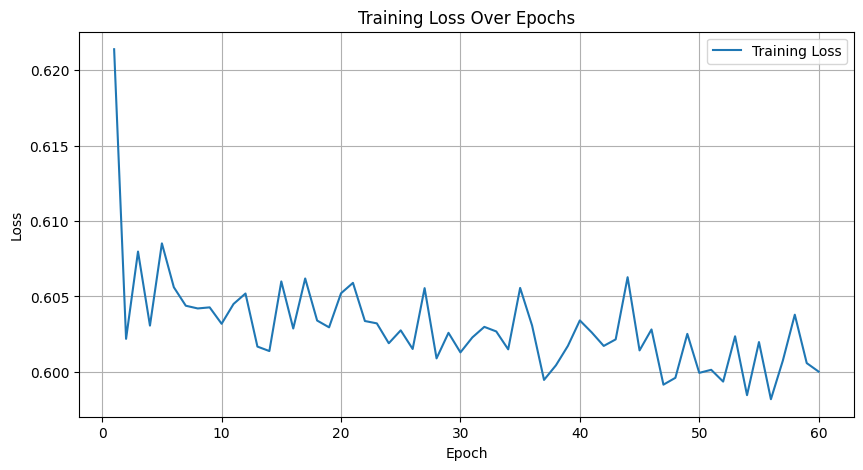

In [ ]:
# Train the model on the whole training set
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device
)

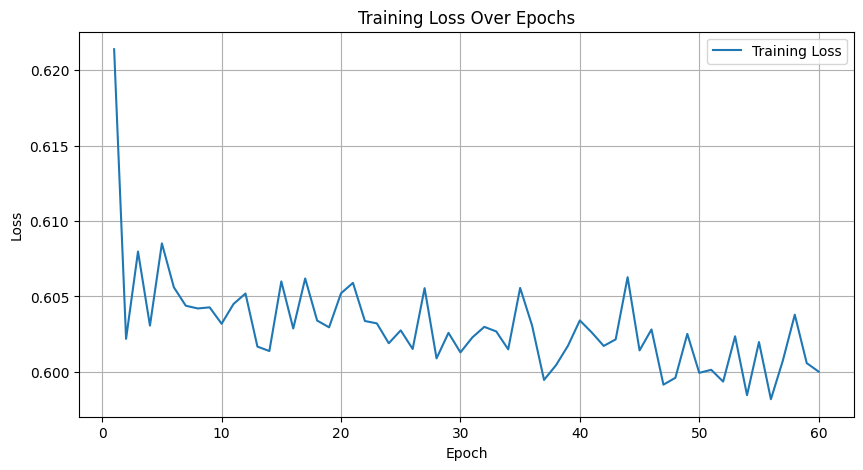

In [ ]:
# Save the final model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/01_dynamic_data/best_models/experiment_2/final_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

**Evaluate the model**

In [ ]:
# Evaluate the final model on the test data
evaluate_model(final_model, test_loader, device)

Accuracy: 0.3284
Precision: 0.3284
Recall (Sensitivity): 1.0000
F1 Score: 0.4944
ROC AUC: 0.4743
Specificity: 0.0000


(0.3283740701381509,
 0.3283740701381509,
 1.0,
 0.49439999999999995,
 0.47428413420179427,
 0.0)

In [ ]:
# Calculate F1 minority
calculate_f1_minority(final_model, test_loader, device)

0.49439999999999995

Strangely the model performance is exactly the same as LSTM with dynamic data.

Even with different architecture, the model performs just as poorly. Clearly this is a data quality issue.

There is no need to analyse the stats again as the data used in the LSTM is analogous.

**Classification threshold**

It may be the case that the threshold for classification is not the standard 0.5.

As such we will investigate different thresholds and see which gives the best metric performance.

In [ ]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

def find_best_threshold_roc_auc(model, test_sequences, test_labels, device):
    """
    Find the best classification threshold based on the ROC AUC score and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_sequences (np.array): The test sequences.
    test_labels (np.array): The true labels for the test data.
    device (torch.device): The device to run the model on.

    Returns:
    float: The best classification threshold.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(test_sequences)):
            sequence = test_sequences[i]
            label = test_labels[i]

            # Convert sequence to torch tensor and reshape to (batch_size, num_features, sequence_length)
            sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).permute(0, 2, 1).to(device)

            # Get model output (predicted probabilities)
            output = model(sequence_tensor)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend([label])

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Find the best threshold based on the ROC AUC score
    best_roc_auc = 0
    best_threshold = 0
    for threshold in thresholds:
        predictions = (all_probs >= threshold).astype(int)
        roc_auc = roc_auc_score(all_labels, predictions)
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_threshold = threshold

    # Final predictions using the best threshold
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    print(f"Best threshold: {best_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return best_threshold

In [ ]:
test_sequences.shape

(941, 13, 12)

In [ ]:
best_threshold = find_best_threshold_roc_auc(final_model, test_sequences, test_labels, device)

Best threshold: 0.8995
Accuracy: 0.6695
Precision: 0.4688
Recall: 0.0485
F1 Score: 0.0880
ROC AUC: 0.4743
Specificity: 0.9731


Like with the LSTM model the best threshold is much higher than 0.5.

**Investigate model prediction and weights**

Check that model weights are being updated properly.

In [ ]:
for name, param in final_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

network.0.conv1.weight tensor([[[-1.1461e-11, -4.0257e-11, -8.0849e-11, -8.0302e-10, -8.3136e-06,
          -1.0958e-05],
         [-3.0194e-11, -9.4574e-12, -4.4580e-12, -2.5776e-12, -6.7371e-05,
          -3.7553e-04],
         [-2.1269e-10, -1.1332e-10, -8.8397e-11, -6.8070e-11, -6.5208e-06,
          -7.1625e-05],
         ...,
         [-2.1656e-10, -8.7359e-11, -9.1932e-11, -3.2897e-10, -5.3794e-05,
          -7.1890e-05],
         [-2.3924e-18, -3.1583e-19, -2.8668e-20, -3.2057e-22, -5.9396e-07,
          -5.6087e-07],
         [-1.0077e-12, -6.5500e-12, -1.8434e-11, -1.0112e-11, -1.5218e-04,
          -8.7141e-05]],

        [[-1.3917e-01, -4.9079e-03,  3.4820e-03, -1.8237e-01,  1.7583e-01,
           1.0793e-01],
         [ 2.2647e-01,  9.3426e-03,  1.6222e-01,  7.1874e-02, -9.4762e-02,
          -1.5138e-01],
         [ 9.7938e-02, -1.1427e-01,  2.1479e-02,  2.9341e-01,  6.2083e-02,
          -2.1704e-01],
         ...,
         [-2.5909e-02,  1.6675e-01,  1.7714e-01,  2.1708

Once again the issue is clearly with the data itself.

This will need to be reviewed and explained properly.

# **Model Interpretability**

**Feature Ablation**

We will now run feature ablation to see how important each feature was in model training.

Ablating feature Inspired O2 Fraction (1/12)
Epoch 0/59, Loss: 1.0235, Val Loss: 0.6527, Val AUC: 0.5181
Epoch 1/59, Loss: 0.8941, Val Loss: 0.6615, Val AUC: 0.5217
Epoch 2/59, Loss: 0.7831, Val Loss: 0.6399, Val AUC: 0.5837
Epoch 3/59, Loss: 0.7614, Val Loss: 0.6433, Val AUC: 0.5705
Epoch 4/59, Loss: 0.7531, Val Loss: 0.6350, Val AUC: 0.5783
Epoch 5/59, Loss: 0.7108, Val Loss: 0.6265, Val AUC: 0.5672
Epoch 6/59, Loss: 0.6906, Val Loss: 0.6221, Val AUC: 0.6002
Epoch 7/59, Loss: 0.6756, Val Loss: 0.6216, Val AUC: 0.5952
Epoch 8/59, Loss: 0.6696, Val Loss: 0.6219, Val AUC: 0.6040
Epoch 9/59, Loss: 0.6712, Val Loss: 0.6241, Val AUC: 0.6078
Epoch 10/59, Loss: 0.6510, Val Loss: 0.6224, Val AUC: 0.6184
Epoch 11/59, Loss: 0.6466, Val Loss: 0.6192, Val AUC: 0.6199
Epoch 12/59, Loss: 0.6458, Val Loss: 0.6343, Val AUC: 0.6260
Epoch 13/59, Loss: 0.6383, Val Loss: 0.6186, Val AUC: 0.6285
Epoch 14/59, Loss: 0.6398, Val Loss: 0.6175, Val AUC: 0.6296
Epoch 15/59, Loss: 0.6305, Val Loss: 0.6149, Val A

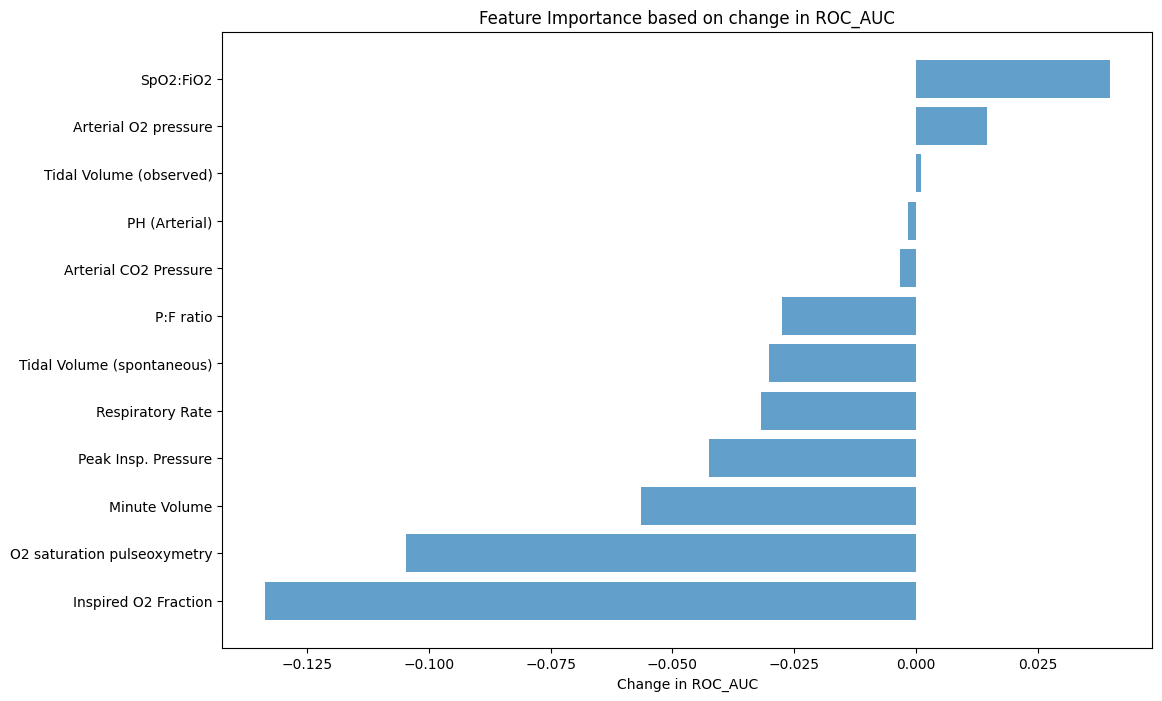

In [ ]:
feature_importances = feature_ablation_with_names(train_sequences, train_labels, test_sequences, test_labels, final_model, best_params, device, feature_names)

In [ ]:
feature_importances

,accuracy,precision,recall,f1,roc_auc,specificity
SpO2:FiO2,0.003188,0.002148,0.009709,0.003622,0.039803,0.000000
Arterial O2 pressure,0.000000,0.000000,0.000000,0.000000,0.014599,0.000000
Tidal Volume (observed),-0.274176,0.035380,0.851133,0.296975,0.001060,-0.824367
PH (Arterial),0.000000,0.000000,0.000000,0.000000,-0.001726,0.000000
Arterial CO2 Pressure,0.000000,0.000000,0.000000,0.000000,-0.003395,0.000000
P:F ratio,0.003188,0.002148,0.009709,0.003622,-0.027457,0.000000
Tidal Volume (spontaneous),-0.004251,0.001180,0.022654,0.004140,-0.030155,-0.017405
Respiratory Rate,0.001063,0.002194,0.016181,0.004473,-0.031820,-0.006329
Peak Insp. Pressure,-0.342189,-0.163934,0.896440,0.323277,-0.042501,-0.947785
Minute Volume,0.002125,0.002171,0.012945,0.004046,-0.056547,-0.003165


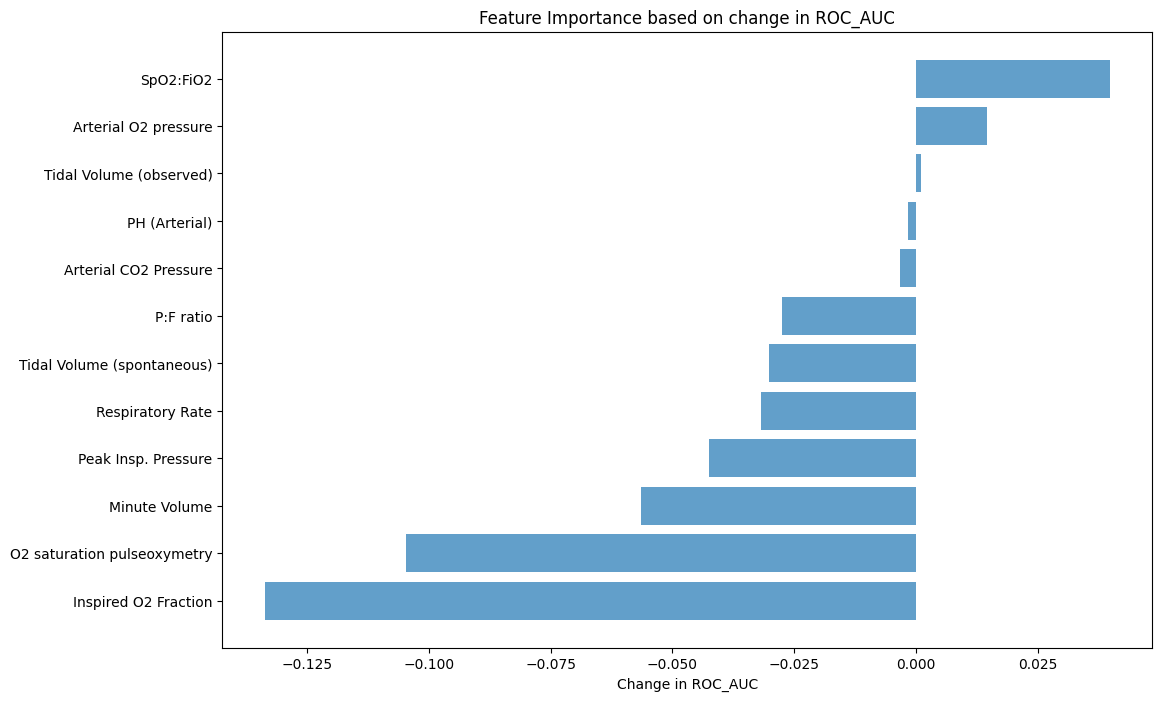

What is very interesting is that once again FiO2 and SaO2 are the most informative features.

The feature importance order also is different to the LSTM model despite the performance being almost identical. Respiratory rate interstingly was the least informative for the LSTM but has a more positive influence here.